# Unsorted Search on Classical Computers

Lets start with how you can search a value in an unsorted list of numbers using classical computers. Let’s take a list of 10 numbers in no particular order, such as, `[3,6,1,9,7,2,5,0,8,4]`. Lets say, you want to search for 8 in this list. Since the list is in no particular order, you will have to check the list items one-by-one till you find a match. If you went from left to right, it would take you 9 tries in this list of 10 numbers.

Checking for the match can be seen as a call to an oracle function, which returns True if the input is the number we are looking for, else returns False. So, the oracle function would be called 9 times before you find 8 in the list. However, if you were searching for 3, then you would be lucky and find it on the first try.

On average, you will need to check a list of $N$ numbers $N/2$ times. In other words, it has time complexity of $O(N)$.

What is exciting though is that on a quantum computer you can perform this search in time-complexity of $O(\sqrt{N})$ using Grover’s algorithm. 

In [1]:
def oracle_classical(n):
    to_match = 8    # this is the number being searched
    if n == to_match:
        return True
    else:
        return False

In [2]:
# This is the unsorted list in which a number is searched
numlist = [3,6,1,9,7,8,5,0,2,4]

num_tries = None # indicates if the list does not contain the number being searched

for i,n in enumerate(numlist):
    if oracle_classical(n):
        num_tries = i + 1
print(num_tries)

6


# Unsorted Search on Quantum Computers: Grover's Algorithm
This notebook implements Grover’s algorithm to achieve the mentioned speedup.  
Grover's algorithm takes advantage of superposition, entanglement, and interference, in quantum computers to get that speedup.

## Install Qucircuit to Run This Notebook
Ensure you have qucircuit installed, the next cell has `pip install` for that.  
Also, take a look [here](https://github.com/atulvarshneya/quantum-computing/tree/master/examples/qckt) for several example algorithm implementations, as well as Getting Started tutorials on qckt.

In [3]:
%pip install qucircuit -qU
%pip show qucircuit

Note: you may need to restart the kernel to use updated packages.
Name: qucircuit
Version: 3.0
Summary: Quantum computer programming with circuits paradigm
Home-page: https://github.com/atulvarshneya/quantum-computing
Author: Atul Varshneya
Author-email: atul.varshneya@gmail.com
License: GPL
Location: /home/atul/anaconda3/envs/py311-qc/lib/python3.11/site-packages
Requires: matplotlib, numpy, qusimulator
Required-by: 
Note: you may need to restart the kernel to use updated packages.


## Import required modules

In [4]:
# Import Qucircuit components
import qckt
from qckt.backend import Qeng
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

## Solution to Dinner Party problem using Grover's algorithm
Dinner Party problem is about selecting a set of friends to invite to a dinner party, while satisfying certain constraints regarding who can be invited along with who. This is basically a boolean satisfiability problem, which belongs to the NP-complete class of problems.

### Problem instance specification
The dinner party constraints for this instance of the problem are the following
- have to invite from among  three friends, creatively named as 0, 1, and 2
- 0 and 1 get along well together; 0 and 2 get along welll together; but 1 and 2 dont get along well
- to invite friends who will get along well together in the dinner party

### Utility functions for building oracle circuit
These functions help in writing the oracle operator.  
Specifically these functions perform the following operations -
* qor(ckt, inplist, out) - this function appends an OR boolean operation to the *ckt* circuit, taking *inplist* as the inputs for the OR, and *out* as the output of that OR.
* qand(ckt,inplist,out) - just as the qor operation above, this appends a boolean AND operation to the circuit *ckt*.
* qnot(ckt,inplist) - this appends NOT boolean operation, i.e., simply X gates, for the target qubits, *inplist*

In [5]:
# Utility functions to implement boolean gates
def qor(ckt,inplist,out):
    ckt.X(inplist)
    ckt.CX(*(inplist+[out]))
    ckt.X(inplist)
    ckt.X(out)

def qand(ckt,inplist,out):
    ckt.CX(*(inplist+[out]))
    
def qnot(ckt,inplist):
    ckt.X(inplist)

### Assign qubits for inputs, output, and work registers
As we start putting together the quantum circuit, we first identify the qubits to be used in the circuit, and their role therein.  
Specifically, we group the qubits into three registers as following:
* Input register, *inreg* - these qubits represent the individual friends invittion status, at the end of the algorithm these are readout to get the result
* Output register, *outreg* - this qubit is the output qubit of the oracle operator, this qubit is initialized to $\ket{-}$ state at the initialization to effect the phase kickback
* Work register, *work* - these qubits are a scratch pad area for the oracle operator to implement its logic. These qubits are required to be cleaned up back to 0 state when the oracle operator is done

In [6]:
inreg = [0,1,2]
work = [3,4,5,6,7]
outreg = [8]

### Grover's circuit components
At the heart of Grover’s algorithm are two operators, the oracle and a reflection operator also known as Grover’s diffusion operator. Additionallly, we need to initialize the input qubits into a uniform superposition, and output qubit into $\ket{-}$ state.

#### Initializer
Initializer circuit puts input register qubits in uniform superposition of all states by applying H gate to each of those qubits. So, the superposition of all states of the input qubits have equal amplitude at the time of initialization. Also, to effect phase kick-back, the output qubit is put in $\ket{-}$ state by applying X gate followed by H gate.

In [7]:
def prepare(prepckt,inreg, outreg):
    prepckt.H(inreg)
    prepckt.X(outreg)
    prepckt.H(outreg)
    return prepckt
prepckt = qckt.QCkt(9)
prepare(prepckt,inreg,outreg).draw()

q000 -[H]---------
                  
q001 -[H]---------
                  
q002 -[H]---------
                  
q003 -------------
                  
q004 -------------
                  
q005 -------------
                  
q006 -------------
                  
q007 -------------
                  
q008 -----[X]-[H]-
                  
creg =============
                  


#### Oracle for Dinner Party problem
The party_oracle circuit implements the boolean logic for the constraints specified earlier for this probelm instance. So, per the specified constraints it indicates if the input  combinations of invitees are mutually compatible. Remember it cleans up the work qubits when done.  
The cell below additionally draws the oracle operator's circuit to help visualize its operation.

In [8]:
def party_oracle(partyckt,inreg,outreg,work):
    # Invite ((0 and 1) or (0 and 2)) and NOT (1 and 2)
    qand(partyckt,[inreg[0],inreg[1]], work[0])
    qand(partyckt,[inreg[0],inreg[2]], work[1])
    qor(partyckt,[work[0],work[1]],work[2])
    qand(partyckt,[inreg[1],inreg[2]], work[3])
    partyckt.X(work[3])
    qand(partyckt,[work[2],work[3]], work[4])
    partyckt.CX(work[4],outreg[0])
    # cleanup the work qubits
    qand(partyckt,[work[2],work[3]], work[4])
    partyckt.X(work[3])
    qand(partyckt,[inreg[1],inreg[2]], work[3])
    qor(partyckt,[work[0],work[1]],work[2])
    qand(partyckt,[inreg[0],inreg[2]], work[1])
    qand(partyckt,[inreg[0],inreg[1]], work[0])
    return partyckt

party_oracle_ckt = qckt.QCkt(9)
party_oracle(party_oracle_ckt, inreg, outreg, work).draw()

q000 -[.]-[.]-------------------------------------------------------------[.]-[.]-
       |   |                                                               |   |  
q001 -[.]--|------------------[.]---------------------[.]------------------|--[.]-
       |   |                   |                       |                   |   |  
q002 --|--[.]-----------------[.]---------------------[.]-----------------[.]--|--
       |   |                   |                       |                   |   |  
q003 -[X]--|--[X]-[.]-[X]------|-----------------------|--[X]-[.]-[X]------|--[X]-
           |       |           |                       |       |           |      
q004 -----[X]-[X]-[.]-[X]------|-----------------------|--[X]-[.]-[X]-----[X]-----
                   |           |                       |       |                  
q005 -------------[X]-----[X]--|------[.]-----[.]------|------[X]-----[X]---------
                               |       |       |       |                          
q006

#### Grover's diffusion operator
The diffusion operator is the trick behind Grover’s operator, it flips every amplitude in the superposition around the mean amplitude. In conjunction with the oracle and phase kick-back, this leads to amplification of the amplitude of the target.

In [9]:
def diffusion_op(diffckt, inreg,outreg):
    # diffuser
    diffckt.H(inreg)
    diffckt.X(inreg)
    diffckt.CX(*(inreg+outreg))
    diffckt.X(outreg)
    diffckt.X(inreg)
    diffckt.H(inreg)
    return diffckt

diffckt = qckt.QCkt(9)
diffusion_op(diffckt, inreg,outreg).draw()

q000 -[H]-[X]-[.]-----[X]-[H]-
               |              
q001 -[H]-[X]-[.]-----[X]-[H]-
               |              
q002 -[H]-[X]-[.]-----[X]-[H]-
               |              
q003 ----------|--------------
               |              
q004 ----------|--------------
               |              
q005 ----------|--------------
               |              
q006 ----------|--------------
               |              
q007 ----------|--------------
               |              
q008 ---------[X]-[X]---------
                              
creg =========================
                              


#### Putting these together to create full quantum circuit for Dinner Party problem
We are now ready to assemble the full quantum circuit using the functions to create the individual components.  
A point to note though, the oracle-diffuser pair requires to be iterated $(\pi/4)\sqrt{N/t}$ times, if there are $t$ solutions to the problem. However, for this instance of this problem we cheat a little bit since we know in advance the number of iteration required is 1.  
In a more general implementation you will need to use an additional step using *Quantum counting algorithm* to efficiently count the number of solutions for the given problem. The quantum counting algorithm is based on the quantum phase estimation algorithm. This algorithm is a separate topic in its own right, we will not discuss it in this notebook.

In [10]:
def build_grover_ckt(groverckt,inreg,outreg,work,n_reps):
    groverckt = prepare(groverckt,inreg,outreg)
    groverckt.Border()
    for i in range(n_reps):
        party_oracle(groverckt,inreg,outreg,work)
        groverckt.Border()
        diffusion_op(groverckt,inreg,outreg)
        groverckt.Border()
    return groverckt

groverckt = qckt.QCkt(9,9, name="Grover's Circuit")
build_grover_ckt(groverckt,inreg,outreg,work,n_reps=1)
groverckt.draw()

Grover's Circuit
q000 -[H]----------#-[.]-[.]-------------------------------------------------------------[.]-[.]--#-[H]-[X]-[.]-----[X]-[H]--#-
                   #  |   |                                                               |   |   #          |               # 
q001 -[H]----------#-[.]--|------------------[.]---------------------[.]------------------|--[.]--#-[H]-[X]-[.]-----[X]-[H]--#-
                   #  |   |                   |                       |                   |   |   #          |               # 
q002 -[H]----------#--|--[.]-----------------[.]---------------------[.]-----------------[.]--|---#-[H]-[X]-[.]-----[X]-[H]--#-
                   #  |   |                   |                       |                   |   |   #          |               # 
q003 --------------#-[X]--|--[X]-[.]-[X]------|-----------------------|--[X]-[.]-[X]------|--[X]--#----------|---------------#-
                   #      |       |           |                       |       |        

# Running the circuit and displaying results

## Function to display measured probabilities
This is a utility function that displays the outcome of the execution of the quantum circuit in a graphical form.

In [11]:
def show_probs(measured_qubits,probs):
    num_qubits = len(measured_qubits)

    probskeys = probs.keys()
    # format the labels
    format_str = '{0:0'+str(num_qubits)+'b}'
    labels = [format_str.format(k) for k in probskeys]
    # get the probabilities
    values = [probs[k] for k in probskeys]

    # plot the probabilities
    plt.bar(labels, values)
    plt.xlabel('bitstrings')
    plt.ylabel('probability')
    plt.xticks(rotation=90)

    return 0

## Running the circuit
Finally we run the circuit a large number of times to get an estimation of the probabilities of the results.  

You should see two possible solutions as $011$ and $101$, i.e., invite friends 0 and 1, or invite friends 0 and 2, and NOT 1 and 2.

0

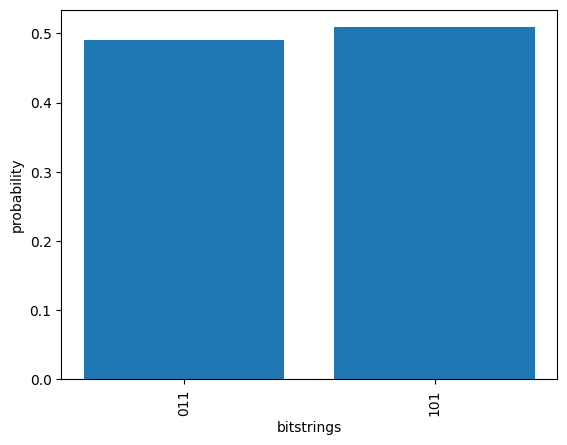

In [12]:
# run the circuit on Qeng backend
shots = 1000
job = qckt.Job(groverckt, shots=shots)
Qeng().runjob(job)

# get result
result = job.get_counts(register=inreg)

# get output probabilities
probs_values = {k: v / shots for k, v in result.items()}

# Plot the probabilities measured
show_probs(inreg,probs_values)